<a href="https://colab.research.google.com/github/ZZnvm/ENVSCI-794_Zihao/blob/main/VRP_new_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q osmnx pyvrp folium openpyxl

import sys, math, numpy as np, pandas as pd
import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt
from pyvrp import Model
from pyvrp.stop import MaxIterations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 9.2 MB/s eta 0:00:00


In [ ]:
# I used same randomised data.
df = pd.read_excel("/test_data/test_data.xlsx", sheet_name=0)

# Normalize columns: location (ID), X (lat), Y (lon)
df = df.rename(columns={"location": "id", "X": "lat", "Y": "lon"})
df = df.dropna(subset=["lat", "lon"]).reset_index(drop=True)

# Depot is id == 0 (first row); rest are clients
df = df.sort_values("id").reset_index(drop=True)
depot = df.iloc[0]
clients = df.iloc[1:].copy()

depot_lat, depot_lon = float(depot["lat"]), float(depot["lon"])
client_lats = clients["lat"].astype(float).tolist()
client_lons = clients["lon"].astype(float).tolist()
names = df["id"].astype(str).tolist()

print(f"Depot @ ({depot_lat:.6f}, {depot_lon:.6f}) | #clients = {len(clients)}")


Depot @ (-36.853500, 174.768400) | #clients = 20


In [ ]:
#
# Bounding box with a small pad (adjust if points are spread out)
pad = 0.01
north = max([depot_lat] + client_lats) + pad
south = min([depot_lat] + client_lats) - pad
east  = max([depot_lon] + client_lons) + pad
west  = min([depot_lon] + client_lons) - pad

# Fetch drivable network
G = ox.graph_from_bbox(north=north, south=south, east=east, west=west, network_type="drive")

# Add speed (km/h) and travel_time (sec) to edges
try:
    G = ox.add_edge_speeds(G)        # v2
    G = ox.add_edge_travel_times(G)  # v2
except AttributeError:
    G = ox.routing.add_edge_speeds(G)        # v1 fallback
    G = ox.routing.add_edge_travel_times(G)  # v1 fallback
# this step shows error , but it's for justise the exact points range for real roads to download. I will fix the error later.
#

TypeError: graph_from_bbox() got an unexpected keyword argument 'north'

In [ ]:
# replace graph_from_bbox with a distance-based fetch, Temporarily replace the previous step with this one.
G = ox.graph_from_point((depot_lat, depot_lon), dist=3000, network_type="drive")  # 3 km radius


In [ ]:
all_lats = [depot_lat] + client_lats
all_lons = [depot_lon] + client_lons

nearest_nodes = ox.distance.nearest_nodes(G, X=all_lons, Y=all_lats)
depot_node = int(nearest_nodes[0])
client_nodes = list(map(int, nearest_nodes[1:]))

print("Depot node:", depot_node, "| First 5 client nodes:", client_nodes[:5])


Depot node: 25769968 | First 5 client nodes: [25769828, 1030160767, 25903956, 25770747, 25769835]


In [ ]:
WEIGHT = "travel_time"  # or "length"
nodes_all = [depot_node] + client_nodes
n = len(nodes_all)

# Pairwise shortest-path costs via Dijkstra
D = np.zeros((n, n), dtype=int)
for i, u in enumerate(nodes_all):
    lengths = nx.single_source_dijkstra_path_length(G, u, weight=WEIGHT)
    for j, v in enumerate(nodes_all):
        if i == j:
            D[i, j] = 0
        else:
            D[i, j] = int(lengths.get(v, 10**12))  # large penalty if disconnected

print("Matrix shape:", D.shape, "| sample row 0:", D[0, :10])


Matrix shape: (21, 21) | sample row 0: [ 0 11 27 14 17  8 21 18 10 27]


use pyvrp to get the best route

In [ ]:
m = Model()

# Add depot (PyVRP likes integer coords; we only use them for reference/plots)
depot_loc = m.add_depot(x=int(round(depot_lon * 1e6)), y=int(round(depot_lat * 1e6)))

# Add clients (ignore demand/service for now)
for r in clients.itertuples():
    m.add_client(
        x=int(round(r.lon * 1e6)),
        y=int(round(r.lat * 1e6)),
        delivery=0,
        service_duration=0,
        name=str(r.id),
    )

# Single vehicle, closed tour
m.add_vehicle_type(num_available=1, capacity=999999, start_depot=depot_loc, end_depot=depot_loc)

# Add edges from our OSM matrix
locs = list(m.locations)  # [depot, client1, client2, ...] — same order as nodes_all
for i, frm in enumerate(locs):
    for j, to in enumerate(locs):
        m.add_edge(frm, to, distance=int(D[i, j]))

res = m.solve(stop=MaxIterations(1000), seed=42, display=True)
best = res.best
print("Objective (sum of distances):", best.distance())


PyVRP v0.11.3

Solving an instance with:
    1 depot
    20 clients
    1 vehicle (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      0s |  33      219      180 |   0        -        -
     1000      1s |  41      202      180 |   0        -        -

Search terminated in 1.28s after 1000 iterations.
Best-found solution has cost 180.

Solution results
    # routes: 1
     # trips: 1
   # clients: 20
   objective: 180
    distance: 180
    duration: 0
# iterations: 1000
    run-time: 1.28 seconds

Objective (sum of distances): 180


In [ ]:
# Expect a single route (we created 1 vehicle). If add more vehicles later, loop over best.routes().
seq = None
for route in best.routes():
    seq = [route.start_depot()] + route.visits() + [route.end_depot()]
    break

# seq indexes m.locations — align with our nodes_all order used for D
print("Visit order (indices in [depot, clients...]):", seq)
print("Visit order (IDs):", [names[i] for i in seq])


Visit order (indices in [depot, clients...]): [0, 12, 17, 7, 19, 14, 10, 8, 4, 3, 15, 13, 18, 2, 5, 1, 9, 6, 11, 20, 16, 0]
Visit order (IDs): ['0', '12', '17', '7', '19', '14', '10', '8', '4', '3', '15', '13', '18', '2', '5', '1', '9', '6', '11', '20', '16', '0']


In [ ]:
#  Map PyVRP indices -> OSM node ids we snapped earlier
# Our locs order = [depot] + clients in df order -> nodes_all in the same order
route_nodes = []
for a, b in zip(seq[:-1], seq[1:]):
    u = nodes_all[a]
    v = nodes_all[b]
    leg = nx.shortest_path(G, u, v, weight=WEIGHT)
    if route_nodes:
        leg = leg[1:]  # avoid duplicate node at joins
    route_nodes.extend(leg)

# To GeoDataFrames (OSMnx v2 API)
route_gdf = ox.routing.route_to_gdf(G, route_nodes, weight="length")  # line geometry of the route
nodes_gdf, edges_gdf = ox.convert.graph_to_gdfs(G)                  # nodes/edges as GeoDataFrames


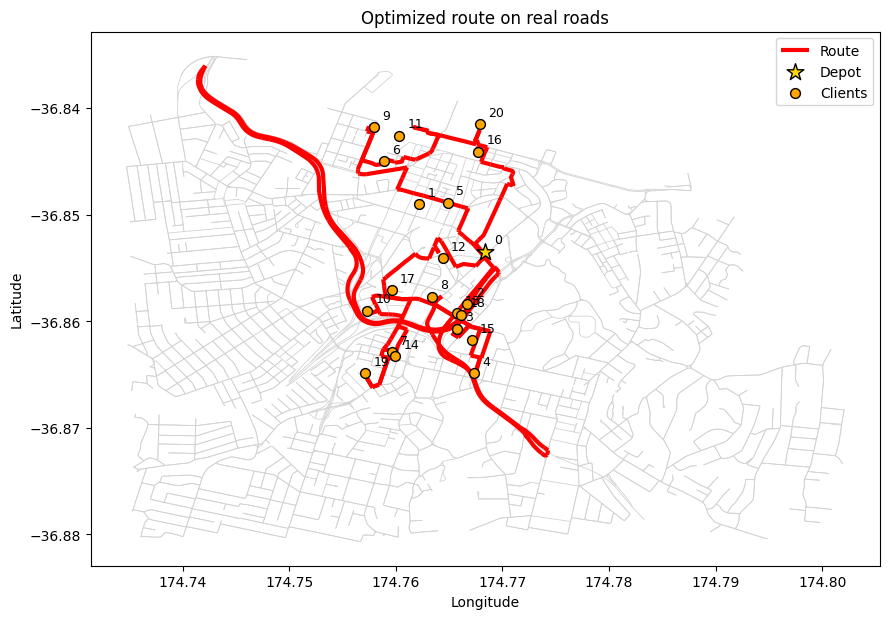

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))
edges_gdf.plot(ax=ax, linewidth=0.6, color="lightgray")

# Route line
route_gdf.plot(ax=ax, linewidth=3, color="red", label="Route")

# Markers
ax.scatter(depot_lon, depot_lat, s=160, marker="*", edgecolors="black", facecolors="gold", zorder=5, label="Depot")
ax.scatter(client_lons, client_lats, s=50, marker="o", edgecolors="black", facecolors="orange", zorder=4, label="Clients")

# One label per point (index labels)
for i, (x, y) in enumerate(zip(df["lon"], df["lat"])):
    ax.annotate(str(df.loc[i, "id"]), (x, y), xytext=(6, 6), textcoords="offset points", fontsize=9)

ax.set_title("Optimized route on real roads")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude"); ax.legend()
ax.set_aspect("equal"); plt.tight_layout(); plt.show()


In [ ]:
import folium

m = folium.Map(location=[depot_lat, depot_lon], zoom_start=13)

# Depot / clients
folium.Marker([depot_lat, depot_lon], icon=folium.Icon(color="blue", icon="home"), tooltip="Depot").add_to(m)
for r in clients.itertuples():
    folium.Marker([r.lat, r.lon], icon=folium.Icon(color="green"), tooltip=f"Client {r.id}").add_to(m)

# Route polyline (lat, lon per node)
route_coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in route_nodes]
folium.PolyLine(route_coords, color="red", weight=5, opacity=0.8, tooltip="Route").add_to(m)

m  # displays in Colab; or: m.save("vrp_route_map.html")
